In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)

In [3]:
train_dataset = train.flow_from_directory("/content/drive/MyDrive/Train",
                                          target_size=(200, 200),
                                          batch_size=10,
                                          class_mode='binary')
validation_dataset = validation.flow_from_directory("/content/drive/MyDrive/Validation",
                                          target_size=(200, 200),
                                          batch_size=10,
                                          class_mode='binary')


Found 1999 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 23, 128)      

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)  # You can add more augmentation techniques if needed

# Load the test dataset
test_dataset = test_datagen.flow_from_directory("/content/drive/MyDrive/Test",
                                                target_size=(200, 200),
                                                batch_size=10,  # Adjust batch size as needed
                                                class_mode='binary',  # Assuming binary classification
                                                shuffle=False)  # Important: Do not shuffle for evaluation

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test accuracy: {test_accuracy*100:.2f}%")


Found 210 images belonging to 2 classes.
21/21 [==============================] - 18s 910ms/step - loss: 0.1240 - accuracy: 0.9667
Test accuracy: 96.67%


In [68]:
model.save('/content/drive/MyDrive/trained_model.h6')


1/1 [==============================] - 0s 73ms/step


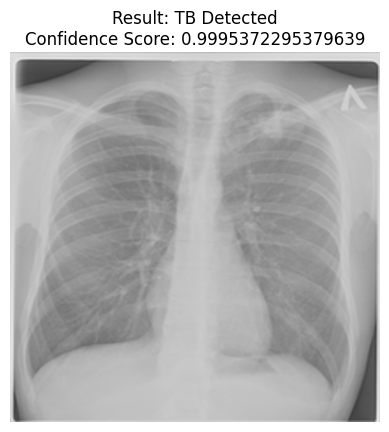

In [100]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/trained_model.h6')


def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (200, 200))
    img = img / 255.0  # Normalize pixel values to between 0 and 1
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


def predict_tb_with_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = loaded_model.predict(preprocessed_img)
    confidence_score = prediction[0][0]

    if confidence_score > 0.5:
        result = "TB Detected"
    else:
        result = "No TB Detected"

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB format

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Result: {result}\nConfidence Score: {confidence_score}")
    plt.show()

image_path = "/content/Tuberculosis-99.png"
predict_tb_with_image(image_path)



In [109]:
# Define data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1/255)


In [120]:
train_dataset = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Train",
    target_size=(256, 256),
    batch_size=10,
    class_mode='binary'
)

# Load the validation data (without augmentation)
validation_dataset = validation_datagen.flow_from_directory(
    "/content/drive/MyDrive/Validation",
    target_size=(256, 256),
    batch_size=10,
    class_mode='binary'
)

Found 1999 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [121]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Define which layers to freeze and which to unfreeze
freeze_layers = 13 # Example: Freeze the first 15 layers, and unfreeze the rest

# Freeze the specified layers
for layer in base_model.layers[:freeze_layers]:
    layer.trainable = False
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = Sequential([
    base_model,  # Include the pre-trained VGG16 model
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model using augmented data
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 32768)             0         
                                                                 
 dense_20 (Dense)            (None, 128)               4194432   
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 18909249 (72.13 MB)
Trainable params: 4194561 (16.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/10
200/200 [==============================] - 67s 329ms/step - loss: 0.2513 - accuracy: 0.8909 - val_loss: 0.1225 - val_accuracy: 

In [123]:
test_datagen = ImageDataGenerator(rescale=1./255)  # You can add more augmentation techniques if needed

# Load the test dataset
test_dataset = test_datagen.flow_from_directory("/content/drive/MyDrive/Test",
                                                target_size=(256, 256),
                                                batch_size=10,  # Adjust batch size as needed
                                                class_mode='binary',  # Assuming binary classification
                                                shuffle=False)  # Important: Do not shuffle for evaluation

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test accuracy: {test_accuracy*100:.2f}%")


Found 210 images belonging to 2 classes.
21/21 [==============================] - 3s 114ms/step - loss: 0.0661 - accuracy: 0.9714
Test accuracy: 97.14%


In [124]:
model.save('/content/drive/MyDrive/trained_model.h3')


1/1 [==============================] - 0s 147ms/step


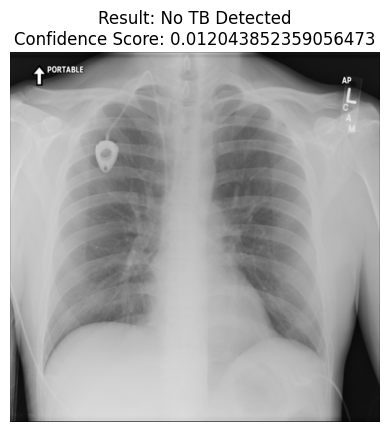

In [130]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/trained_model.h3')


def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0  # Normalize pixel values to between 0 and 1
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


def predict_tb_with_image(image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = loaded_model.predict(preprocessed_img)
    confidence_score = prediction[0][0]

    if confidence_score > 0.5:
        result = "TB Detected"
    else:
        result = "No TB Detected"

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB format

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Result: {result}\nConfidence Score: {confidence_score}")
    plt.show()

image_path = "/content/Normal-996.png"
predict_tb_with_image(image_path)

